In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation

from datetime import datetime

# **DATA**

In [32]:
new_market = pd.read_csv('./new_market.csv')
new_market['pricingDate'] = pd.to_datetime(new_market['pricingDate'])
# 2018.05.01 ~ 2023.04.30 기간 데이터 필터링
filtered_data = new_market[(new_market['pricingDate'] >= '2018-05-01') & (new_market['pricingDate'] <= '2023-04-30')]

In [33]:
ticker_15 = ['AAPL', 'AMZN', 'NVDA', 'JPM', 'PG', 'PFE', 'JNJ', 'KO', 'XOM', 'NEE',
             'GOOGL', 'MSFT', 'TSLA', 'NKE', 'BAC']

ticker_30 = ['MSFT', 'AMZN', 'NVDA', 'AAPL', 'GOOGL', 'ADBE', 'JNJ', 'PFE', 'MRK', 
             'ABT', 'PG', 'KO', 'JPM', 'GS', 'CAT', 'CVX', 'XOM', 'BA', 'TSLA', 'NEE', 
             'NKE', 'VZ', 'CRM', 'UNH', 'WMT', 'QCOM', 'BAC', 'V', 'MCD', 'INTC']

ticker_45 = ['AAPL', 'GOOGL', 'MSFT', 'NVDA', 'AMD', 'ORCL', 'CRM', 'INTC', 'CSCO', 
             'JPM', 'GS', 'BAC', 'MS', 'AXP', 'C', 'JNJ', 'UNH', 'PFE', 'ABBV', 'TSLA', 
             'AMGN', 'GILD', 'PG', 'KO', 'NKE', 'PEP', 'COST', 'WMT', 'TGT', 'XOM', 
             'CVX', 'NEE', 'DUK', 'SO', 'SLB', 'MMM', 'CAT', 'HON', 'GE', 'ADP', 'AMZN', 
             'META', 'HD', 'VZ', 'MRK']

a = ['pricingDate'] + ticker_15
b = ['pricingDate'] + ticker_30
c = ['pricingDate'] + ticker_45
 
ticker_15_price = filtered_data[a]
ticker_30_price = filtered_data[b]
ticker_45_price = filtered_data[c]

In [35]:
ticker_15_price.to_csv('./ticker_15_price.csv')
ticker_30_price.to_csv('./ticker_30_price.csv')
ticker_45_price.to_csv('./ticker_45_price.csv')

# **GPT-weighted Portfolio simulation**

In [36]:
gpt_weighted_15 = {
    "AAPL": 0.084, "AMZN": 0.074, "NVDA": 0.064, "JPM": 0.054, "PG": 0.054,
    "PFE": 0.064, "JNJ": 0.064, "KO": 0.054, "XOM": 0.064, "NEE": 0.074,
    "GOOGL": 0.084, "MSFT": 0.084, "TSLA": 0.074, "NKE": 0.054, "BAC": 0.054
}

gpt_weighted_30 = {
    "MSFT": 0.067, "AMZN": 0.067, "NVDA": 0.067, "AAPL": 0.067, "GOOGL": 0.067,
    "ADBE": 0.067, "JNJ": 0.05, "PFE": 0.05, "MRK": 0.05, "ABT": 0.05, 
    "PG": 0.05, "KO": 0.05, "JPM": 0.05, "GS": 0.05, "CAT": 0.025, 
    "CVX": 0.025, "XOM": 0.025, "BA": 0.025, "TSLA": 0.025, "NEE": 0.025, 
    "NKE": 0.005, "VZ": 0.005, "CRM": 0.005, "UNH": 0.005, "WMT": 0.005, 
    "QCOM": 0.005, "BAC": 0.005, "V": 0.005, "MCD": 0.005, "INTC": 0.005
}

gpt_weighted_45 = {
    "AAPL": 0.05, "GOOGL": 0.04, "MSFT": 0.04, "NVDA": 0.03, "AMD": 0.03, 
    "ORCL": 0.02, "CRM": 0.02, "INTC": 0.01, "CSCO": 0.01, "JPM": 0.04, 
    "GS": 0.03, "BAC": 0.03, "MS": 0.02, "AXP": 0.02, "C": 0.01,
    "JNJ": 0.03, "UNH": 0.03, "PFE": 0.02, "ABBV": 0.02, "TSLA": 0.02, 
    "AMGN": 0.02, "GILD": 0.01, "PG": 0.03, "KO": 0.03, "NKE": 0.02, 
    "PEP": 0.02, "COST": 0.02, "WMT": 0.02, "TGT": 0.01, "XOM": 0.025, 
    "CVX": 0.025, "NEE": 0.02, "DUK": 0.01, "SO": 0.01, "SLB": 0.01,
    "MMM": 0.02, "CAT": 0.02, "HON": 0.02, "GE": 0.02, "ADP": 0.02,
    "AMZN": 0.02, "META": 0.02, "HD": 0.02, "VZ": 0.01, "MRK": 0.01
}

## 15 Portfolio

In [38]:
# 2018.05.01 ~ 2023.04.30 기간에서 30일씩 3번에 걸쳐서 랜덤하게 선택되는 시나리오를 1000개 만들기

# 각 시나리오 부분별로 필요한 일수
days_per_part = 30

num_scenarios = 1000
total_days = ticker_15_price.shape[0]

scenarios = []

# 각 시나리오를 3개의 랜덤한 30일로 구성

for _ in range(num_scenarios):
   
    scenario_data = pd.DataFrame()

    # 사용된 일자를 추적하기 위한 집합
    used_days = set()

    for _ in range(3):
        # 중복되지 않는 30일 기간을 선택
        while True:
            start_day = np.random.randint(0, total_days - days_per_part)
            end_day = start_day + days_per_part

            # 선택된 기간이 이전에 사용된 일자와 중복되지 않는지 확인
            if not used_days.intersection(set(range(start_day, end_day))):
                break

        # 사용된 일자 업데이트
        used_days.update(range(start_day, end_day))

        # 데이터셋에서 30일 기간의 데이터 추출
        part_data = ticker_15_price.iloc[start_day:end_day]

        # 추출된 30일 데이터를 시나리오 데이터에 추가
        scenario_data = pd.concat([scenario_data, part_data])

    # 완성된 시나리오 데이터를 시나리오 목록에 추가
    scenarios.append(scenario_data)


scenarios[0]


,pricingDate,AAPL,AMZN,NVDA,JPM,PG,PFE,JNJ,KO,XOM,NEE,GOOGL,MSFT,TSLA,NKE,BAC
219,2019-03-15,44.910626,85.6180,42.169871,92.299352,91.550883,33.420152,121.948361,39.402523,63.324748,43.348584,59.5150,110.762291,18.362000,82.971423,26.282987
220,2019-03-18,45.369095,87.1075,41.956303,92.853755,90.719739,33.444149,121.567273,39.498203,64.059521,43.264715,59.4275,112.348569,17.966000,83.946433,26.749443
221,2019-03-19,45.009559,88.0925,43.635052,92.515915,91.068283,33.836104,122.692813,39.628674,63.893604,42.727505,60.1230,112.425016,17.831333,83.822167,26.596947
222,2019-03-20,45.402877,89.8635,43.309732,90.540857,90.907417,33.732116,121.673623,39.602580,64.249139,43.038044,61.3215,112.300789,18.240000,82.866275,25.690947
223,2019-03-21,47.075081,90.9630,45.678854,89.111538,91.595568,33.876099,122.391488,39.585184,64.620476,43.500453,61.8065,114.880879,18.268000,84.128052,25.278313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,2021-06-25,131.390788,170.0730,190.007811,143.319361,127.604054,35.958007,154.599909,50.772854,58.991764,70.271161,122.5085,259.806886,223.956666,150.747979,39.367429
795,2021-06-28,133.039219,172.1945,199.532662,143.579857,127.982364,36.087153,154.421028,50.716772,57.486406,71.498480,122.5360,263.434105,229.573333,148.804419,39.310677
796,2021-06-29,134.569200,172.4070,199.949499,143.403092,127.112250,36.068704,154.430443,50.342892,57.130595,70.480471,122.2725,266.061387,226.920000,152.310640,38.676938
797,2021-06-30,135.191063,172.0080,199.707384,144.705573,127.613511,36.124052,155.098891,50.576567,57.550270,69.719343,122.0895,265.571223,226.566666,150.884712,38.998537


In [43]:
# 시나리오가 랜덤하게 잘 구성되었는지 확인

scenario0 = scenarios[0]
scenario1 = scenarios[1]
scenario2 = scenarios[2]
scenario3 = scenarios[3]

In [40]:
# 각 시나리오에 대해 주어진 가중치를 적용하여 포트폴리오의 성과를 평가 (기간 전체수익률)

# 포트폴리오 성과를 계산하는 함수
def calculate_portfolio_performance(scenario, weights):
    # 시작일과 종료일의 가격을 추출
    start_prices = scenario.iloc[0][list(weights.keys())]
    end_prices = scenario.iloc[-1][list(weights.keys())]

    # 가중치에 따라 포트폴리오의 성과를 계산
    performance = ((end_prices - start_prices) / start_prices) * list(weights.values())
    return performance.sum()

# 각 시나리오에 대한 포트폴리오 성과를 계산
portfolio_performances = [calculate_portfolio_performance(scenario, gpt_weighted_15) for scenario in scenarios]

portfolio_performances[:10]

[1.7354154370418156,
 0.654899354569357,
 2.293143154752971,
 0.14605395672237526,
 -0.45181824639098817,
 2.346037747915832,
 -0.21668902567587073,
 -0.19110739317358802,
 0.0958019735589707,
 0.01208669916705936]

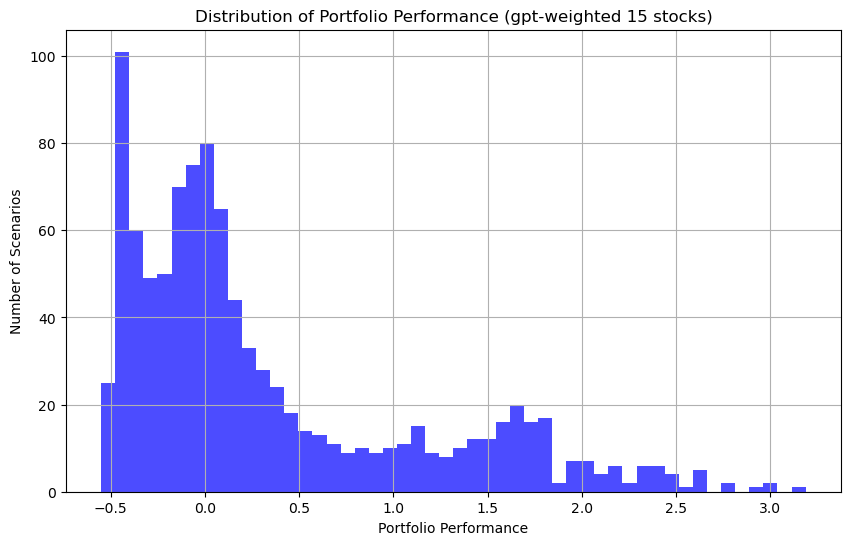

In [41]:
# 시나리오별 포트폴리오 성과 시각화
plt.figure(figsize=(10, 6))
plt.hist(portfolio_performances, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Portfolio Performance (gpt-weighted 15 stocks)')
plt.xlabel('Portfolio Performance')
plt.ylabel('Number of Scenarios')
plt.grid(True)
plt.show()

In [66]:
# 평균과 표준편차 계산
mean_performance = np.mean(portfolio_performances)
std_dev_performance = np.std(portfolio_performances)

mean_performance, std_dev_performance

(0.32855747811437935, 0.7872637750816398)

In [67]:
#시나리오 주간 기대수익률, 표준편차 계산

# 각 시나리오에 대해 가중치가 적용된 수익률을 계산하는 함수
def calculate_weighted_returns(scenario, weights):
   
    # 날짜(비수치데이터) 제거
    scenario_numeric = scenario.select_dtypes(include=[np.number])

    # 가중치가 적용된 수익률 계산
    weighted_returns = scenario_numeric.multiply(weights) 
    total_returns = weighted_returns.sum(axis=1)
    return total_returns

#각 시나리오에 대한 주간 수익률 통계를 계산하는 함수
def calculate_weekly_statistics(scenarios, weights):

    weekly_stats = []

    for scenario in scenarios:
        # 총 가중치가 적용된 수익률 계산
        total_returns = calculate_weighted_returns(scenario, weights)

        # 주간 수익률 계산
        weekly_returns = total_returns.pct_change(periods=7).dropna() # 이 부분은 t-7 ~ t 기간의 주간 수익률을 계산함. 1~7일은 nan값이 나오므로 dropna()를 통해 제거함. 즉 8~90일의 주간 수익률을 계산한 결과이므로 83개의 주간 수익률이 나옴.

        # 통계 계산
        mean_return = weekly_returns.mean()
        std_deviation = weekly_returns.std()

        weekly_stats.append((mean_return, std_deviation))

    return weekly_stats

In [45]:
# 시나리오 분석 수행
weights_series_gpt_15 = pd.Series(gpt_weighted_15) # 각각의 가중치 시리즈만 넣어서 만들면 됨(여기서는 일단 gpt_weighted_15만 넣음)
weekly_statistics_gpt_15 = calculate_weekly_statistics(scenarios, weights_series_gpt_15) 

# 첫 번째 시나리오의 통계를 예시로 표시
weekly_statistics_gpt_15[0]

(0.0794654293149607, 0.21171650190787367)

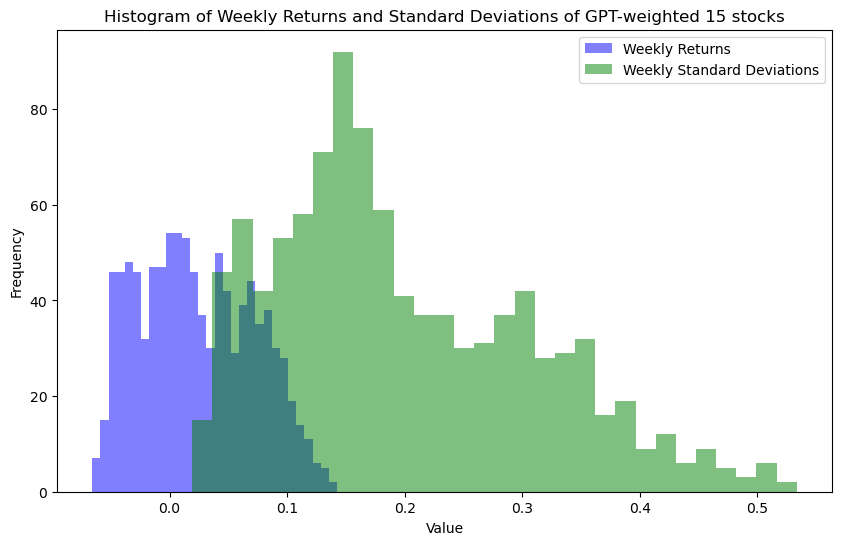

In [51]:
returns_15, std_devs_15 = zip(*weekly_statistics_gpt_15)

plt.figure(figsize=(10, 6))

# 리턴과 표준편차에 대한 히스토그램을 같은 축에 겹쳐 표시
plt.hist(returns_15, bins=30, alpha=0.5, label='Weekly Returns', color='blue')
plt.hist(std_devs_15, bins=30, alpha=0.5, label='Weekly Standard Deviations', color='green')

# 범례 추가
plt.legend(loc='upper right')

plt.title('Histogram of Weekly Returns and Standard Deviations of GPT-weighted 15 stocks')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

# **Mean-Variance Optimization**

In [9]:
new_market = pd.read_csv('./new_market.csv', index_col=0)
new_market

,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
pricingDate,,,,,,,,,,,,,,,,,,,,,
2018-05-01,63.574105,42.342797,40.191708,79.940979,53.921780,26.876666,140.357973,224.08,79.992862,38.801281,...,180.343060,39.841488,58.326616,47.887170,65.827974,78.555893,108.770822,136.78,46.462606,80.580399
2018-05-02,63.257386,41.249072,41.967178,78.609543,53.032556,26.310000,139.240061,221.10,79.488744,38.284275,...,179.572242,39.747543,58.212919,47.839888,64.434146,72.716789,109.245154,133.12,46.580767,77.198727
2018-05-03,63.670080,41.122121,42.043236,78.539055,53.105894,25.983333,140.182433,226.05,79.137661,37.569084,...,180.126855,39.696300,58.015844,46.563275,65.135737,74.956321,107.124611,133.54,45.956201,77.662499
2018-05-04,64.303518,41.854527,43.692736,78.452903,53.848442,26.276666,141.762291,228.51,81.262162,37.793120,...,180.869471,39.619435,58.288717,47.272504,65.556692,74.738715,108.091876,134.67,46.808649,78.802606
2018-05-07,64.677822,41.541303,44.008850,78.029977,54.380142,26.376666,140.709052,230.99,81.469211,37.646635,...,180.399461,39.397382,58.925421,44.369392,65.500564,75.355266,108.808024,137.48,46.850849,79.372659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-04,111.670000,12.730000,173.660000,147.690000,95.650000,80.460000,308.112102,518.42,173.790000,73.470000,...,88.210000,56.630000,111.500000,33.300000,91.220000,123.530000,109.690000,230.94,33.330000,170.990000
2023-10-05,110.350000,12.850000,174.910000,147.450000,96.200000,81.640000,308.380987,516.44,172.100000,73.130000,...,89.490000,56.480000,108.990000,32.180000,90.140000,121.840000,109.300000,222.54,33.400000,172.000000
2023-10-06,110.640000,12.760000,177.490000,148.240000,96.880000,82.180000,310.900537,526.68,173.970000,72.860000,...,92.410000,57.350000,107.170000,32.480000,90.970000,119.460000,110.910000,223.85,33.690000,175.580000


In [7]:
new_market['pricingDate'] = pd.to_datetime(new_market['pricingDate'])
new_market.set_index('pricingDate', inplace=True)

# 평균, 공분산 계산
mu = expected_returns.mean_historical_return(new_market)
Sigma = risk_models.sample_cov(new_market)

# Efficient Frontier
ef = EfficientFrontier(mu, Sigma)
weights = ef.min_volatility()


cleaned_weights = ef.clean_weights()
print("Optimized Portfolio Weights:")
print(cleaned_weights)

# 최적화
latest_prices = new_market.iloc[-1]  # Use the latest prices
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.lp_portfolio()
allocation, leftover

Optimized Portfolio Weights:
OrderedDict([('A', 0.0), ('AAL', 0.0), ('AAPL', 0.0), ('ABBV', 0.02224), ('ABT', 0.0), ('ACGL', 0.0), ('ACN', 0.0), ('ADBE', 0.0), ('ADI', 0.0), ('ADM', 0.0), ('ADP', 0.0), ('ADSK', 0.0), ('AEE', 0.0), ('AEP', 0.0), ('AES', 0.0), ('AFL', 0.0), ('AIG', 0.0), ('AIZ', 0.0), ('AJG', 0.0), ('AKAM', 0.0), ('ALB', 0.0), ('ALGN', 0.0), ('ALK', 0.0), ('ALL', 0.0), ('ALLE', 0.0), ('AMAT', 0.0), ('AMD', 0.0), ('AME', 0.0), ('AMGN', 0.0), ('AMP', 0.0), ('AMT', 0.0), ('AMZN', 0.0), ('ANET', 0.0), ('ANSS', 0.0), ('AON', 0.0), ('AOS', 0.0), ('APA', 0.0), ('APD', 0.0), ('APH', 0.0), ('APTV', 0.0), ('ARE', 0.0), ('ATO', 0.0), ('AVB', 0.0), ('AVGO', 0.0), ('AVY', 0.0), ('AWK', 0.0), ('AXON', 0.0), ('AXP', 0.0), ('AZO', 0.0), ('BA', 0.0), ('BAC', 0.0), ('BALL', 0.0), ('BAX', 0.0), ('BBWI', 0.0), ('BBY', 0.0), ('BDX', 0.0), ('BEN', 0.0), ('BF.B', 0.0), ('BG', 0.0), ('BIO', 0.0), ('BK', 0.0), ('BKNG', 0.0), ('BKR', 0.0), ('BLK', 0.0), ('BMY', 0.06595), ('BR', 0.0), ('BRO', 0.0)

In [ ]:
# 아래는 예시로 대략적으로 작성한 가상의 데이터입니다.

raw_price_data = {
    'AAPL': [150, 153, 151, 152, 155],
    'GOOGL': [2800, 2820, 2810, 2850, 2900],
    'MSFT': [300, 305, 302, 303, 310],
    # ... 다른 주식 데이터 ...
}

# 데이터프레임으로 변환합니다.
df = pd.DataFrame(raw_price_data)

# 수익률과 공분산 행렬 계산
mu = expected_returns.mean_historical_return(df)
Sigma = risk_models.sample_cov(df)

# 포트폴리오 최적화
ef = EfficientFrontier(mu, Sigma)
weights = ef.min_volatility()

# 최적화된 결과 출력
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

# 포트폴리오 할당량 계산
latest_prices = df.iloc[-1]  # 최신 주가를 사용하여 할당량 계산
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.lp_portfolio()
print("포트폴리오 할당량:", allocation)
print("잔여 현금:", leftover)